In [315]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import train_test_split and preprocessing libraries / classes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import ML models for regression problems
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Import model performace metric libraries
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Import for optimization
from sklearn.model_selection import GridSearchCV

In [316]:
path = 'cleaned_dataset.csv'

df = pd.read_csv(path)
df.head()

certificate  runtime                   genre  imdb_rating  meta_score  \
0  all public      142                   Drama          9.3        80.0   
1  all public      175  Thriller/Crime/Mystery          9.2       100.0   
2      family      152        Action/Adventure          9.0        84.0   
3  all public      202  Thriller/Crime/Mystery          9.0        90.0   
4  all public       96  Thriller/Crime/Mystery          9.0        96.0   

   no_of_votes        gross director_category star1_category star2_category  \
0      2343110   28341469.0           average            low            low   
1      1620367  134966411.0              high        average        average   
2      2303232  534858444.0              high           high        average   
3      1129952   57300000.0              high           high        average   
4       689845    4360000.0              high        average            low   

  star3_category star4_category  decade  
0            low            low  1990's  
1            low        average  1970's  
2            low           high  2000's  
3        average        average  1970's  
4            low            low  1950's

In [317]:
df.shape

(713, 13)

In [318]:
df.describe()

runtime  imdb_rating  meta_score   no_of_votes         gross
count  713.000000   713.000000  713.000000  7.130000e+02  7.130000e+02
mean   123.692847     7.937588   77.158485  3.562568e+05  7.837989e+07
std     25.898509     0.293211   12.409849  3.541346e+05  1.150031e+08
min     72.000000     7.600000   28.000000  2.522900e+04  1.305000e+03
25%    104.000000     7.700000   70.000000  9.582600e+04  6.153939e+06
50%    120.000000     7.900000   78.000000  2.363110e+05  3.470029e+07
75%    136.000000     8.100000   86.000000  5.084170e+05  1.023089e+08
max    238.000000     9.300000  100.000000  2.343110e+06  9.366622e+08

In [319]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   certificate        713 non-null    object 
 1   runtime            713 non-null    int64  
 2   genre              713 non-null    object 
 3   imdb_rating        713 non-null    float64
 4   meta_score         713 non-null    float64
 5   no_of_votes        713 non-null    int64  
 6   gross              713 non-null    float64
 7   director_category  713 non-null    object 
 8   star1_category     713 non-null    object 
 9   star2_category     713 non-null    object 
 10  star3_category     713 non-null    object 
 11  star4_category     713 non-null    object 
 12  decade             713 non-null    object 
dtypes: float64(3), int64(2), object(8)
memory usage: 72.5+ KB


<Axes: xlabel='imdb_rating', ylabel='no_of_votes'>

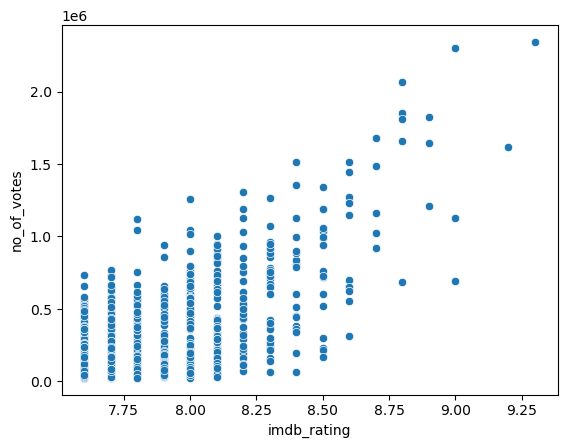

In [320]:
sns.scatterplot(data=df, x="imdb_rating", y="no_of_votes")

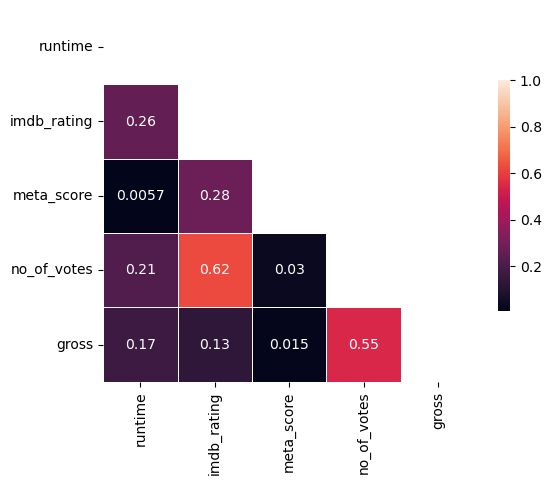

In [321]:
original_numerical_columns = df.select_dtypes('number')

corr = np.abs(original_numerical_columns.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [322]:
# Define which columns could be dropped due to low correlation and poor model performance.

cols_to_drop = [
    'meta_score',
    'star2_category',
    'star3_category',
    'star4_category'
]

df = df.drop(columns=cols_to_drop)

In [323]:
# Define our target and features.
target = df['no_of_votes']
features = df.drop('no_of_votes', axis=1)

# Split dataset into categorical and numerical
categorical_features = features.select_dtypes(['object', 'bool'])
numerical_features = features.drop(categorical_features, axis=1)
features.shape

(713, 8)

In [324]:
# Now we perform the division between Train and Test, we will reserve 20% of our data to Test.
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [325]:
# Initiate OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

# Split training set into categorical and numerical
X_train_cat = X_train.select_dtypes(['object', 'bool'])
X_train_num = X_train.drop(X_train_cat, axis=1)

# Fit OneHotEncoder with the categorical data and transform it into numerical values
ohe.fit(X_train_cat)
X_train_trans_np = ohe.transform(X_train_cat)

# Create a dataframe using the transformed values and the original index
X_train_trans_df = pd.DataFrame(X_train_trans_np, columns=ohe.get_feature_names_out(), index=X_train.index)

# Concatenate the newly transformed train dataframe with the train numerical dataframe
X_train = pd.concat([X_train_trans_df, X_train_num], axis=1)
X_train.head()

certificate_all public  certificate_family  certificate_over 18  \
692                     1.0                 0.0                  0.0   
266                     0.0                 1.0                  0.0   
17                      1.0                 0.0                  0.0   
477                     1.0                 0.0                  0.0   
302                     0.0                 1.0                  0.0   

     genre_Action/Adventure  genre_Comedy  genre_Drama  genre_Other  \
692                     0.0           1.0          0.0          0.0   
266                     0.0           0.0          1.0          0.0   
17                      0.0           0.0          1.0          0.0   
477                     0.0           0.0          0.0          1.0   
302                     0.0           1.0          0.0          0.0   

     genre_Thriller/Crime/Mystery  director_category_average  \
692                           0.0                        1.0   
266                           0.0                        1.0   
17                            0.0                        1.0   
477                           0.0                        0.0   
302                           0.0                        0.0   

     director_category_high  ...  decade_1950's  decade_1960's  decade_1970's  \
692                     0.0  ...            0.0            0.0            0.0   
266                     0.0  ...            0.0            0.0            0.0   
17                      0.0  ...            0.0            0.0            1.0   
477                     0.0  ...            0.0            0.0            1.0   
302                     0.0  ...            0.0            0.0            0.0   

     decade_1980's  decade_1990's  decade_2000's  decade_2010's  runtime  \
692            0.0            1.0            0.0            0.0      103   
266            0.0            1.0            0.0            0.0      189   
17             0.0            0.0            0.0            0.0      133   
477            0.0            0.0            0.0            0.0       72   
302            0.0            0.0            0.0            1.0      130   

     imdb_rating        gross  
692          7.6  285761243.0  
266          8.0   70405498.0  
17           8.7  112000000.0  
477          7.8     193817.0  
302          7.9  165359751.0  

[5 rows x 26 columns]

In [326]:
# Split test set into categorical and numerical
X_test_cat = X_test.select_dtypes(['object', 'bool'])
X_test_num = X_test.drop(X_test_cat, axis=1)

# Transform the categorical data into numerical values
X_test_trans_np = ohe.transform(X_test_cat)

# Create a dataframe using the transformed values and the original index
X_test_trans_df = pd.DataFrame(X_test_trans_np, columns=ohe.get_feature_names_out(), index=X_test.index)

# Concatenate the newly transformed test dataframe with the test numerical dataframe
X_test = pd.concat([X_test_trans_df, X_test_num], axis=1)
X_test.head()

certificate_all public  certificate_family  certificate_over 18  \
338                     1.0                 0.0                  0.0   
142                     1.0                 0.0                  0.0   
242                     1.0                 0.0                  0.0   
235                     1.0                 0.0                  0.0   
468                     0.0                 1.0                  0.0   

     genre_Action/Adventure  genre_Comedy  genre_Drama  genre_Other  \
338                     1.0           0.0          0.0          0.0   
142                     0.0           0.0          0.0          1.0   
242                     0.0           0.0          1.0          0.0   
235                     0.0           0.0          0.0          0.0   
468                     0.0           1.0          0.0          0.0   

     genre_Thriller/Crime/Mystery  director_category_average  \
338                           0.0                        0.0   
142                           0.0                        1.0   
242                           0.0                        1.0   
235                           1.0                        1.0   
468                           0.0                        1.0   

     director_category_high  ...  decade_1950's  decade_1960's  decade_1970's  \
338                     1.0  ...            0.0            0.0            0.0   
142                     0.0  ...            0.0            0.0            0.0   
242                     0.0  ...            0.0            0.0            0.0   
235                     0.0  ...            0.0            0.0            0.0   
468                     0.0  ...            0.0            0.0            0.0   

     decade_1980's  decade_1990's  decade_2000's  decade_2010's  runtime  \
338            0.0            0.0            1.0            0.0      142   
142            0.0            0.0            0.0            1.0       95   
242            0.0            0.0            0.0            1.0      126   
235            0.0            0.0            1.0            0.0       88   
468            1.0            0.0            0.0            0.0       97   

     imdb_rating        gross  
338          7.9  249358727.0  
142          8.1  356461711.0  
242          8.0    2086345.0  
235          8.0     238507.0  
468          7.8   45875171.0  

[5 rows x 26 columns]

In [327]:
normalizer = MinMaxScaler()
normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns, index = X_train.index)
X_train_norm.head()

X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns, index = X_test.index)
X_test_norm.head()

certificate_all public  certificate_family  certificate_over 18  \
338                     1.0                 0.0                  0.0   
142                     1.0                 0.0                  0.0   
242                     1.0                 0.0                  0.0   
235                     1.0                 0.0                  0.0   
468                     0.0                 1.0                  0.0   

     genre_Action/Adventure  genre_Comedy  genre_Drama  genre_Other  \
338                     1.0           0.0          0.0          0.0   
142                     0.0           0.0          0.0          1.0   
242                     0.0           0.0          1.0          0.0   
235                     0.0           0.0          0.0          0.0   
468                     0.0           1.0          0.0          0.0   

     genre_Thriller/Crime/Mystery  director_category_average  \
338                           0.0                        0.0   
142                           0.0                        1.0   
242                           0.0                        1.0   
235                           1.0                        1.0   
468                           0.0                        1.0   

     director_category_high  ...  decade_1950's  decade_1960's  decade_1970's  \
338                     1.0  ...            0.0            0.0            0.0   
142                     0.0  ...            0.0            0.0            0.0   
242                     0.0  ...            0.0            0.0            0.0   
235                     0.0  ...            0.0            0.0            0.0   
468                     0.0  ...            0.0            0.0            0.0   

     decade_1980's  decade_1990's  decade_2000's  decade_2010's   runtime  \
338            0.0            0.0            1.0            0.0  0.421687   
142            0.0            0.0            0.0            1.0  0.138554   
242            0.0            0.0            0.0            1.0  0.325301   
235            0.0            0.0            1.0            0.0  0.096386   
468            1.0            0.0            0.0            0.0  0.150602   

     imdb_rating     gross  
338     0.176471  0.266220  
142     0.294118  0.380565  
242     0.235294  0.002226  
235     0.235294  0.000253  
468     0.117647  0.048976  

[5 rows x 26 columns]

In [328]:
# Create a variable to use as the max_samples option in Bagging and Pasting below. This ensures no error.
number_of_samples = X_train_norm.shape[0]
number_of_test_rows = X_test_norm.shape[0]
max_samples = min(1000, number_of_samples)

# Create a variable to hold the scores of each model
#scores = []

### Gradient Boosting

In [329]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [200, 250],
    'learning_rate': [0.1],
    'max_depth': [8, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 4],
    'subsample': [0.7, 0.8]
}

# Initialize the GradientBoostingRegressor
gb_reg = GradientBoostingRegressor()

# Initialize GridSearchCV with the GradientBoostingRegressor
grid_search = GridSearchCV(estimator=gb_reg, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_train_norm, y_train)

# Get the best estimator
best_gb = grid_search.best_estimator_

# Make predictions with the best estimator
pred = best_gb.predict(X_test_norm)

score = {
    'model': 'GradientBoostingRegressor',
    'optimized': True,
    'mean_absolute_error': round(mean_absolute_error(y_test, pred), 2),
    'mean_squared_error': round(mean_squared_error(y_test, pred, squared=False), 2),
    'r2_score': round(best_gb.score(X_test_norm, y_test), 2),
}

metrics = grid_search.best_params_
score.update(metrics)

scores.append(score)
score

{'model': 'GradientBoostingRegressor',
 'optimized': True,
 'mean_absolute_error': 115998.92,
 'mean_squared_error': 164379.56,
 'r2_score': 0.8,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 250,
 'subsample': 0.7}

In [330]:
#scores_df = pd.DataFrame(scores).sort_values('r2_score', ascending=False).round(2)
scores_df = pd.DataFrame(scores).round(2)
scores_df

model  optimized  mean_absolute_error  \
0   GradientBoostingRegressor      False            153802.87   
1   GradientBoostingRegressor       True            116227.66   
2   GradientBoostingRegressor       True            118697.41   
3   GradientBoostingRegressor       True            122252.87   
4   GradientBoostingRegressor       True            115925.73   
5   GradientBoostingRegressor       True            114557.63   
6   GradientBoostingRegressor       True            120298.30   
7   GradientBoostingRegressor       True            113746.57   
8   GradientBoostingRegressor       True            143946.61   
9   GradientBoostingRegressor       True            131029.48   
10  GradientBoostingRegressor       True            133774.77   
11  GradientBoostingRegressor       True            130608.58   
12  GradientBoostingRegressor       True            137403.32   
13  GradientBoostingRegressor       True            121656.78   
14  GradientBoostingRegressor       True            115641.92   
15  GradientBoostingRegressor       True            110601.38   
16  GradientBoostingRegressor       True            111862.07   
17  GradientBoostingRegressor       True            126208.37   
18  GradientBoostingRegressor       True            113250.84   
19  GradientBoostingRegressor       True            110789.33   
20  GradientBoostingRegressor       True            115056.37   
21  GradientBoostingRegressor       True            118557.73   
22  GradientBoostingRegressor       True            113615.17   
23  GradientBoostingRegressor       True            119459.20   
24  GradientBoostingRegressor       True            115527.05   
25  GradientBoostingRegressor       True            116955.26   
26  GradientBoostingRegressor       True            115998.92   

    mean_squared_error  r2_score  learning_rate  max_depth  min_samples_leaf  \
0            230470.00      0.61            NaN        NaN               NaN   
1            166968.32      0.80            0.1       20.0               4.0   
2            171735.84      0.79            0.1       10.0               1.0   
3            173551.48      0.78            0.2       30.0               4.0   
4            163283.27      0.81            0.1       10.0               4.0   
5            164485.49      0.80            0.1       20.0               4.0   
6            172151.62      0.78            0.1       20.0               2.0   
7            165246.50      0.80            0.1       20.0               2.0   
8            195335.08      0.72            0.1       10.0               1.0   
9            175881.89      0.78            0.1        8.0               4.0   
10           183197.85      0.76            0.1        8.0               3.0   
11           181166.18      0.76            0.1        9.0               2.0   
12           186964.68      0.75            0.1        8.0               3.0   
13           172109.78      0.78            0.1        8.0               4.0   
14           160397.53      0.81            0.1        9.0               4.0   
15           155874.01      0.82            0.1        9.0               4.0   
16           164259.35      0.80            0.1        9.0               3.0   
17           175204.50      0.78            0.1       10.0               3.0   
18           166108.92      0.80            0.1       10.0               4.0   
19           155177.32      0.83            0.1       10.0               4.0   
20           162462.12      0.81            0.1        8.0               4.0   
21           171457.23      0.79            0.1       10.0               3.0   
22           161348.00      0.81            0.1       10.0               3.0   
23           166028.27      0.80            0.2       10.0               4.0   
24           166493.13      0.80            0.1        8.0               4.0   
25           167167.64      0.80            0.1        8.0               4.0   
26           164379.56      0.80           

In [331]:
# Create the DataFrame
df_combined = pd.DataFrame({
    'actual_values': y_test,  # Concatenate y_train and y_test to get actual values
    'predicted_values': pred
})

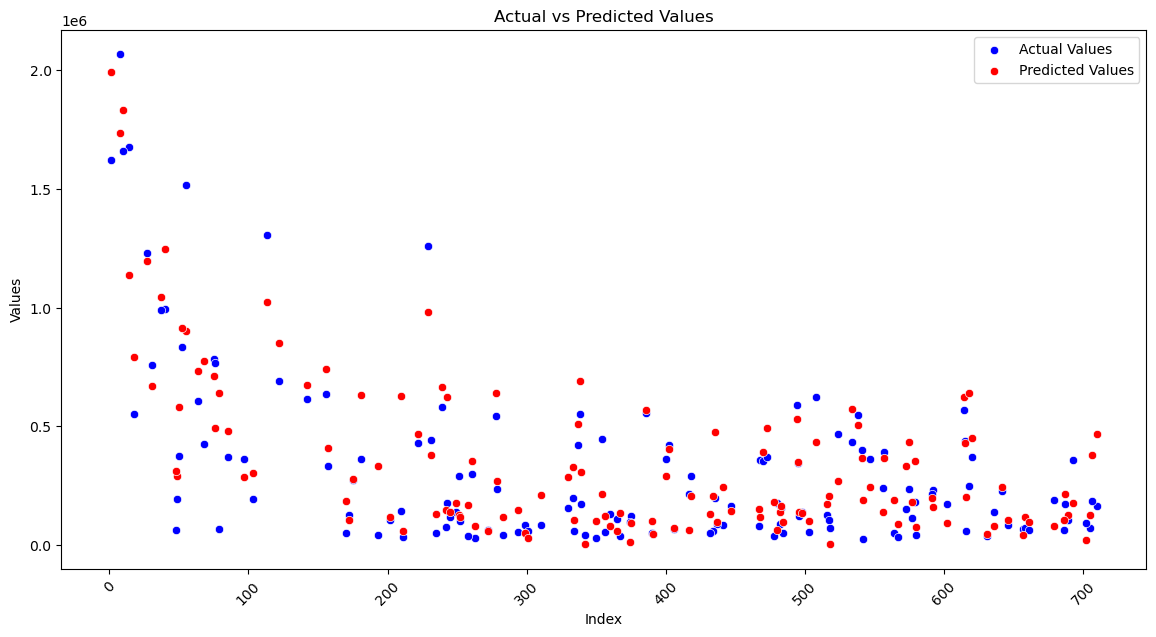

In [332]:
# Plotting
plt.figure(figsize=(14, 7))

# Plot actual values
sns.scatterplot(data=df_combined, x=df_combined.index, y='actual_values', label='Actual Values', color='blue')

# Plot predicted values
sns.scatterplot(data=df_combined, x=df_combined.index, y='predicted_values', label='Predicted Values', color='red')

# Customize the plot
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Rotate x-ticks if necessary
plt.xticks(rotation=45)

# Show the plot
plt.show()